In [80]:
from devito import *
from examples.seismic import *
from examples.seismic.acoustic import AcousticWaveSolver

from extra_plotting import *
from datasets.bilayered import BilayeredDataset
from variable_density import VariableDensityAcousticWaveSolver
from seismic_wrapper.model_creation import gardners_relation

In [81]:
import numpy as np
%matplotlib inline

configuration['log-level'] = 'WARNING'

- Equação direta

$$
Au = S
$$
$$
A = \frac{\partial^2}{\partial t^2} - \kappa \nabla \cdot (b \nabla) + \eta \frac{\partial}{\partial t}
$$

- Equação adjunta

$$
A^Tv = R
$$
$$
A^T = \frac{\partial^2}{\partial t^2} -  \nabla \cdot b (\nabla \kappa) - \frac{\partial}{\partial t}\eta
$$

In [82]:
filter_sigma = (16, 16)
nshots = 21
nreceivers = 101
t0 = 0.
tn = 1000.
f0 = 0.010

shape = (101, 101)
spacing = (10., 10.)
origin = (0., 0.)
space_order = 8
time_order = 2
nbl = 20

In [83]:
def create_model(model: Model = None):
    if model:
        return Model(
            vp=model.vp.data[model.nbl:-model.nbl, model.nbl:-model.nbl],
            origin=model.origin, 
            shape=model.shape, 
            spacing=model.spacing, 
            space_order=model.space_order,
            grid=model.grid,
            nbl=model.nbl,
            b=model.b.data[model.nbl:-model.nbl, model.nbl:-model.nbl],
            bcs='damp'
        )
    else:
        vp1 = 1.5
        vp2 = 2.5
        rho1 = gardners_relation(vp1)
        rho2 = gardners_relation(vp2)
        bilayer_dataset = BilayeredDataset(vp1, vp2, rho1, rho2)
        model = bilayer_dataset.model
        model.space_order = space_order
        return create_model(model)

# True and smooth velocity models

First, we create the model data for the "true" model from a given demonstration preset. This model represents the subsurface topology for the purposes of this example and we will later use it to generate our synthetic data readings. We also generate a second model and apply a smoothing filter to it, which represents our initial model for the imaging algorithm. The perturbation between these two models can be thought of as the image we are trying to recover.

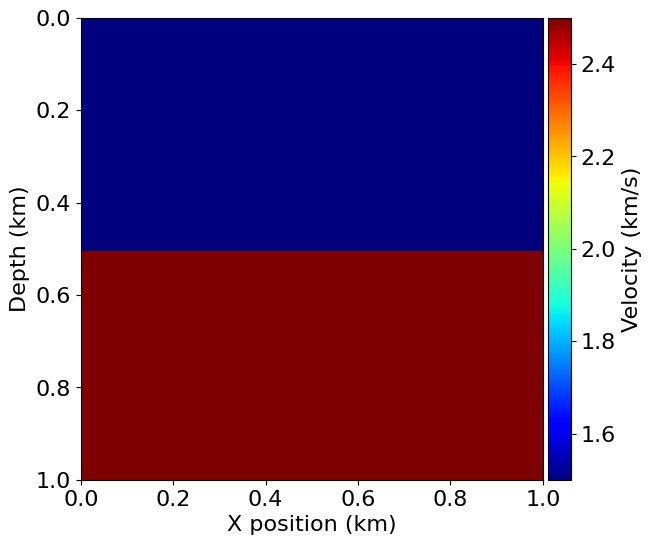

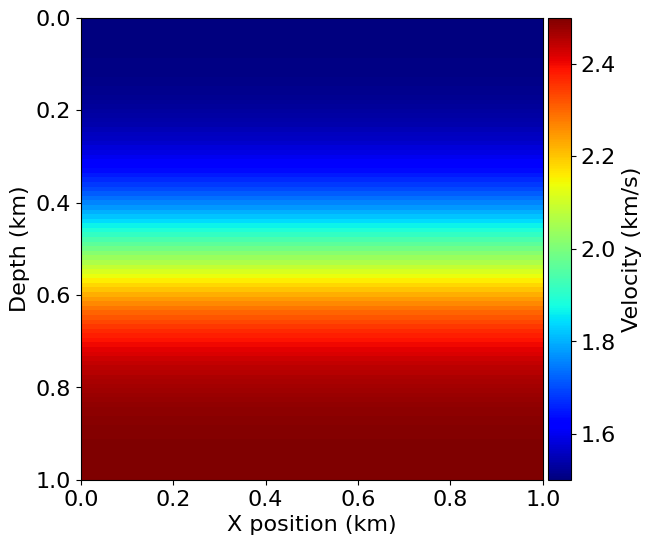

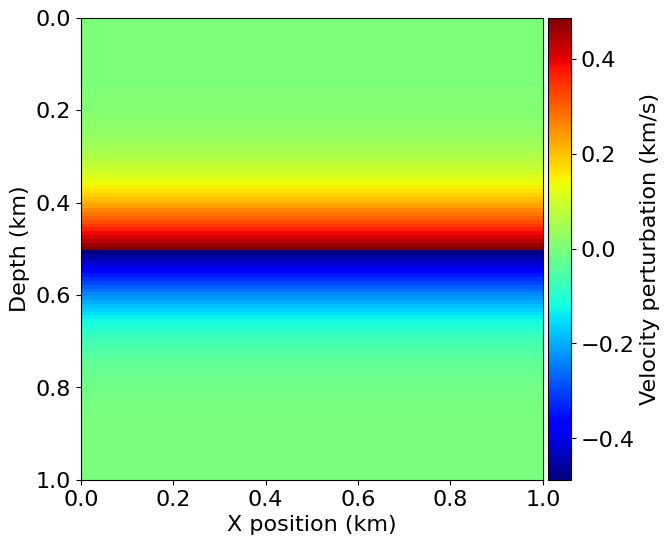

In [84]:
model = create_model()
model0 = create_model(model)

gaussian_smooth(model0.vp, sigma=filter_sigma)
gaussian_smooth(model0.b.data, sigma=filter_sigma)

plot_velocity(model)
plot_velocity(model0)
plot_perturbation(model0, model)

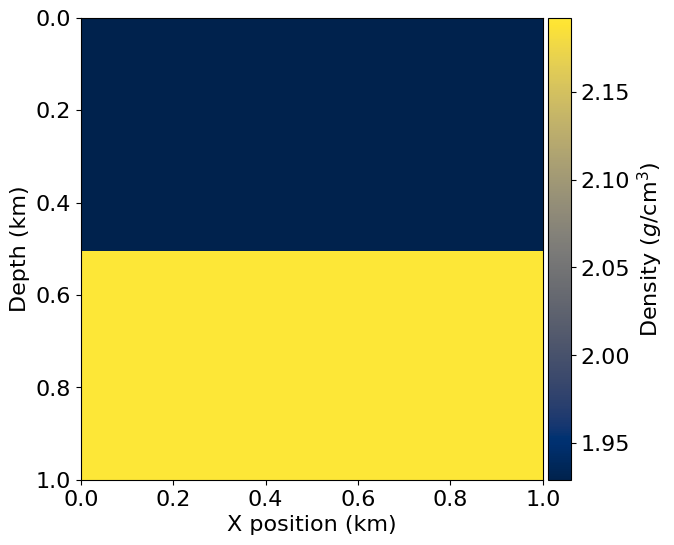

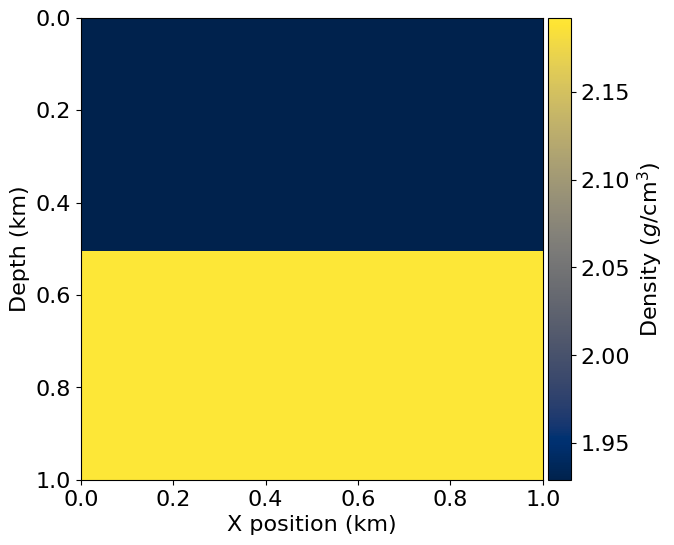

In [85]:
plot_density(model)
plot_density(model0)

## Acquisition geometry

Next we define the positioning and the wave signal of our source, as well as the location of our receivers. To generate the wavelet for our source we require the discretized values of time that we are going to use to model a single "shot",
which again depends on the grid spacing used in our model. For consistency this initial setup will look exactly as in the previous modelling tutorial, although we will vary the position of our source later on during the actual imaging algorithm.

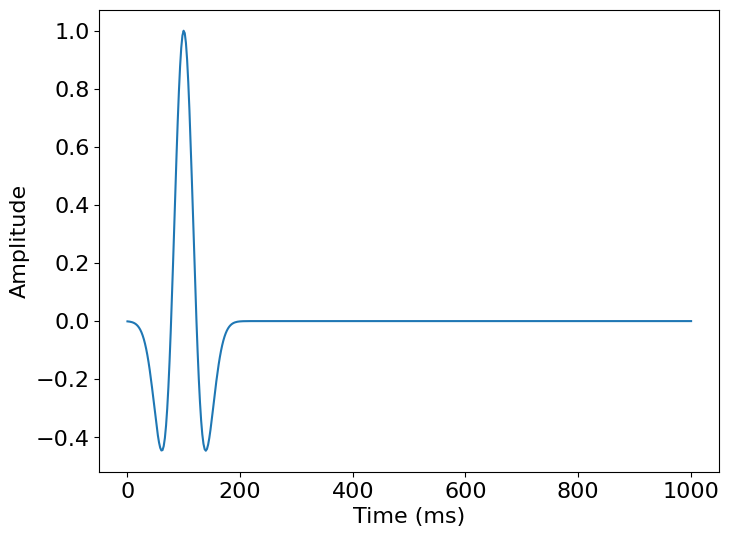

In [86]:
src_coordinates = np.empty((1, 2))
src_coordinates[0, :] = np.array(model.domain_size) * .5
src_coordinates[0, -1] = 20.  # Depth is 20m

rec_coordinates = np.empty((nreceivers, 2))
rec_coordinates[:, 0] = np.linspace(0, model.domain_size[0], num=nreceivers)
rec_coordinates[:, 1] = 30.

geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates, t0, tn, f0=f0, src_type='Ricker')
geometry.src.show()

# True and smooth data

We can now generate the shot record (receiver readings) corresponding to our true and initial models. The difference between these two records will be the basis of the imaging procedure.

For this purpose we will use the same forward modelling operator that was introduced in the previous tutorial, provided by the `AcousticWaveSolver` utility class. This object instantiates a set of pre-defined operators according to an initial definition of the acquisition geometry, consisting of source and receiver symbols. The solver objects caches the individual operators and provides a slightly more high-level API that allows us to invoke the modelling modelling operators from the initial tutorial in a single line. In the following cells we use this to generate shot data by only specifying the respective model symbol `m` to use, and the solver will create and return a new `Receiver` object the represents the readings at the previously defined receiver coordinates.  

In [87]:
solver = VariableDensityAcousticWaveSolver(model, geometry, space_order=space_order)
true_d , _, _ = solver.forward(vp=model.vp, b = model.b)
smooth_d, _, _= solver.forward(vp=model0.vp, b = model0.b)

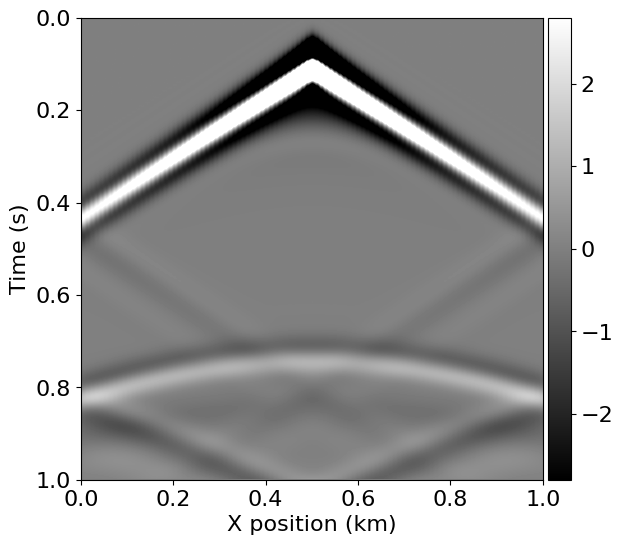

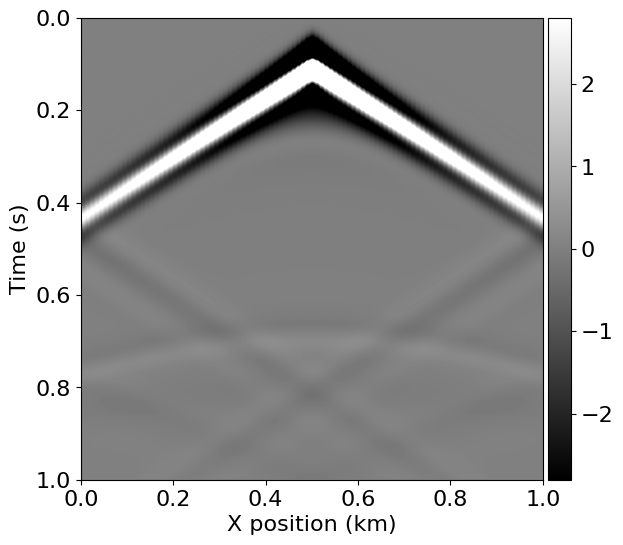

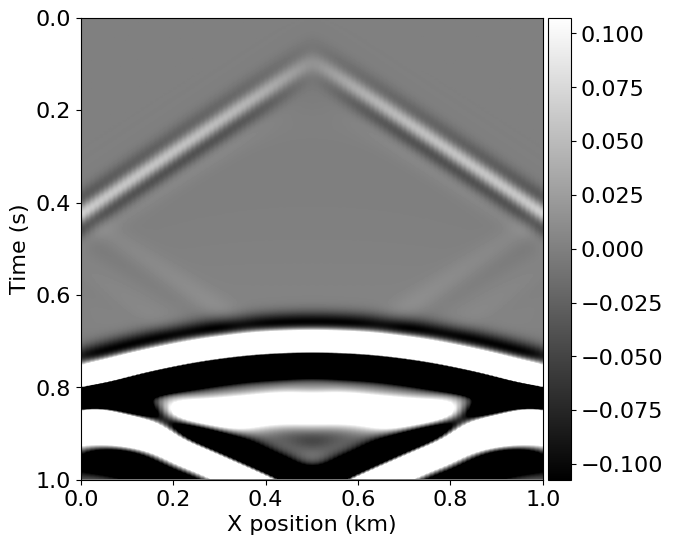

In [88]:
plot_shotrecord(true_d.data, model, t0, tn)
plot_shotrecord(smooth_d.data, model, t0, tn)
plot_shotrecord(smooth_d.data - true_d.data, model, t0, tn)

# Imaging with back-propagation

As explained in the introduction of this tutorial, this method is based on back-propagation. 

## Adjoint wave equation

If we go back to the modelling part, we can rewrite the simulation as a linear system solve:

\begin{equation}
\mathbf{A}(\mathbf{m}) \mathbf{u} = \mathbf{q}
\end{equation}

where $\mathbf{m}$ is the discretized square slowness, $\mathbf{q}$ is the discretized source and $\mathbf{A}(\mathbf{m})$ is the discretized wave-equation. The discretized wave-equation matricial representation is a lower triangular matrix that can be solve with forward substitution. The pointwise writing or the forward substitution leads to the time-stepping stencil.

On a small problem one could form the matrix explicitly and transpose it to obtain the adjoint discrete wave-equation:

\begin{equation}
\mathbf{A}(\mathbf{m})^T \mathbf{v} = \delta \mathbf{d}
\end{equation}

where $\mathbf{v}$ is the discrete **adjoint wavefield** and  $\delta \mathbf{d}$ is the data residual defined as the difference between the field/observed data and the synthetic data $\mathbf{d}_s = \mathbf{P}_r \mathbf{u}$. In our case we derive the discrete adjoint wave-equation from the discrete forward wave-equation to get its stencil. 

## Imaging

Wave-equation based imaging relies on one simple concept:

- If the background velocity model is cinematically correct, the forward wavefield $\mathbf{u}$ and the adjoint wavefield $\mathbf{v}$ meet at the reflectors position at zero time offset. 

The sum over time of the zero time-offset correlation of these two fields then creates an image of the subsurface. Mathematically this leads to the simple imaging condition:

\begin{equation}
  \text{Image} = \sum_{t=1}^{n_t} \mathbf{u}[t] \mathbf{v}[t]
\end{equation}

In the following tutorials we will describe a more advanced imaging condition that produces shaper and more accurate results.

## Operator

We will now define the imaging operator that computes the adjoint wavefield $\mathbf{v}$ and correlates it with the forward wavefield $\mathbf{u}$. This operator essentially consists of three components:
* Stencil update of the adjoint wavefield `v`
* Injection of the data residual at the adjoint source (forward receiver) location
* Correlation of `u` and `v` to compute the image contribution at each timestep

$$
I_{s} = \sum_t u_s[t]v_s[t]\\
$$

$$
I = \sum_s I_s
$$

In [89]:
def ImagingOperator(model, image, rec_illum, geometry):
    v = TimeFunction(name='v', grid=model.grid, time_order=2, space_order=space_order)

    u = TimeFunction(name='u', grid=model.grid, time_order=2, space_order=space_order,
                     save=geometry.nt)
    

    kappa = 1/(model.b * model.m)
    eqn = v.dt2 - div(model.b * grad(kappa * v, shift=0.5), shift=-0.5) + model.damp * v.dt.T

    stencil = Eq(v.backward, solve(eqn, v.backward))
    dt = model.critical_dt
    residual = PointSource(name='residual', grid=model.grid,
                           time_range=geometry.time_axis,
                           coordinates=geometry.rec_positions)
    res_term = residual.inject(field=v.backward, expr=residual * dt**2 / model.m)

    image_update = Eq(image, image + u * v)
    rec_illum_update = Eq(rec_illum, rec_illum + v*v)

    return Operator([stencil] + res_term + [image_update] + [rec_illum_update],
                    subs=model.spacing_map)

## Implementation of the imaging loop

As just explained, the forward wave-equation is solved forward in time while the adjoint wave-equation is solved in a reversed time order. Therefore, the correlation of these two fields over time requires to store one of the two fields. The computational procedure for imaging follows:

- Simulate the forward wave-equation with the background velocity model to get the synthetic data and save the full wavefield $\mathbf{u}$
- Compute the data residual
- Back-propagate the data residual and compute on the fly the image contribution at each time step. 

This procedure is applied to multiple source positions (shots) and summed to obtain the full image of the subsurface. We can first visualize the varying locations of the sources that we will use. 

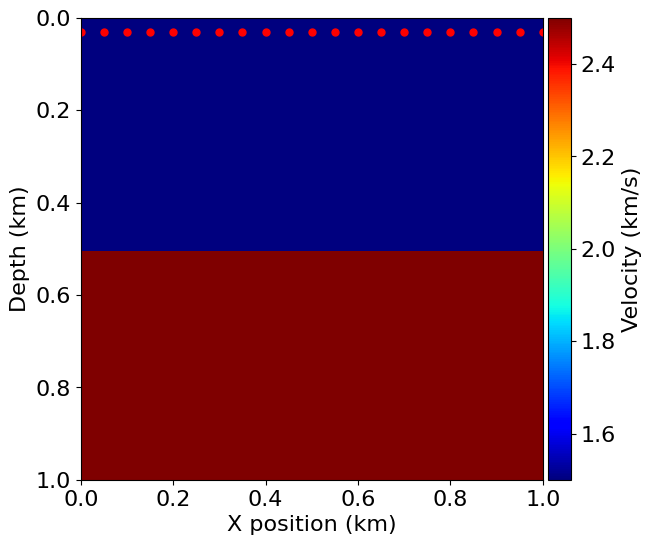

In [90]:
#NBVAL_IGNORE_OUTPUT

# Prepare the varying source locations
source_locations = np.empty((nshots, 2), dtype=np.float32)
source_locations[:, 0] = np.linspace(0., 1000, num=nshots)
source_locations[:, 1] = 30.

plot_velocity(model, source=source_locations)

In [91]:
image = Function(name='image', grid=model.grid, space_order=space_order)
rec_illum = Function(name='rec_illum', grid=model.grid)
op_imaging = ImagingOperator(model, image, rec_illum, geometry)

for i in range(nshots):
    print('Imaging source %d out of %d' % (i+1, nshots))
    
    geometry.src_positions[0, :] = source_locations[i, :]

    true_d, _, _ = solver.forward(vp=model.vp)
    smooth_d, u0, _ = solver.forward(vp=model0.vp, save=True)
    
    v = TimeFunction(name='v', grid=model.grid, time_order=2, space_order=space_order, staggered = NODE)
    residual = smooth_d.data - true_d.data
    op_imaging(u=u0, v=v, vp=model0.vp, b=model0.b, dt=model0.critical_dt, residual=residual, damp=model0.damp)


Imaging source 1 out of 21
Imaging source 2 out of 21
Imaging source 3 out of 21
Imaging source 4 out of 21
Imaging source 5 out of 21
Imaging source 6 out of 21
Imaging source 7 out of 21
Imaging source 8 out of 21
Imaging source 9 out of 21
Imaging source 10 out of 21
Imaging source 11 out of 21
Imaging source 12 out of 21
Imaging source 13 out of 21
Imaging source 14 out of 21
Imaging source 15 out of 21
Imaging source 16 out of 21
Imaging source 17 out of 21
Imaging source 18 out of 21
Imaging source 19 out of 21
Imaging source 20 out of 21
Imaging source 21 out of 21


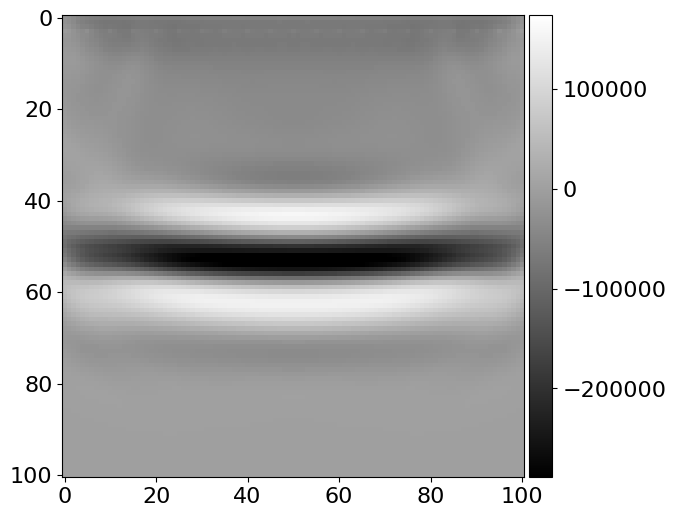

In [92]:
plot_image(image.data[model.nbl: -model.nbl, model.nbl: -model.nbl])

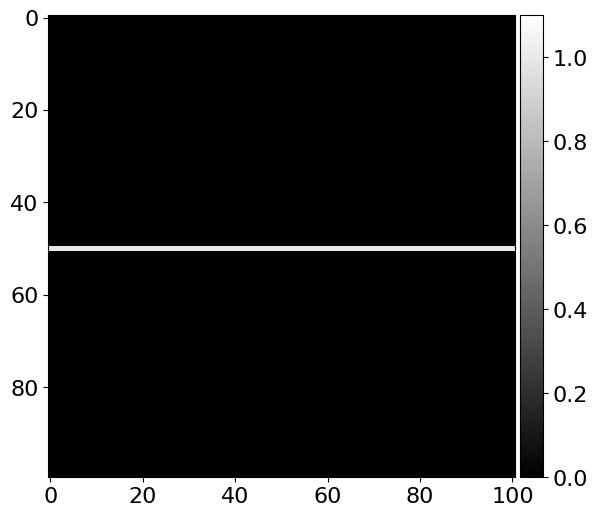

In [93]:
plot_image(np.diff(model.vp.data[model.nbl: -model.nbl, model.nbl: -model.nbl], axis=1))

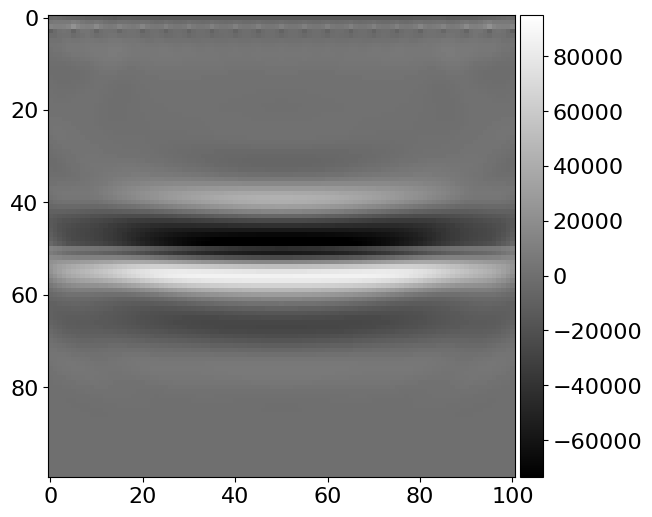

In [94]:
plot_image(np.diff(image.data[model.nbl: -model.nbl, model.nbl: -model.nbl], axis=1))

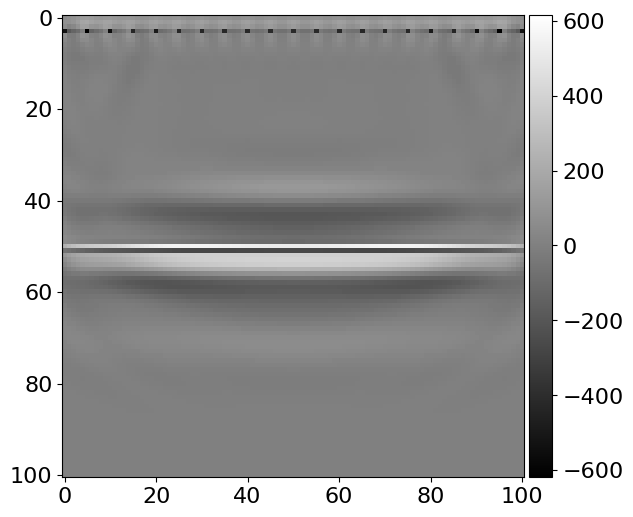

In [95]:
laplace_result = Function(name='lap', grid=model.grid, space_order=space_order)
stencil = Eq(laplace_result, image.laplace)
Operator([stencil])()

plot_image(laplace_result.data[model.nbl: -model.nbl, model.nbl: -model.nbl])

In [96]:
assert np.isclose(norm(image), 1e7, rtol=1e1)

And we have an image of the subsurface with a strong reflector at the original location.

## References

[1] _Versteeg, R.J. & Grau, G. (eds.) (1991): The Marmousi experience. Proc. EAGE workshop on Practical Aspects of Seismic Data Inversion (Copenhagen, 1990), Eur. Assoc. Explor. Geophysicists, Zeist._